In [503]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import string
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')


In [504]:
fake = pd.read_csv("Data/Fake.csv")
true = pd.read_csv("Data/True.csv")

true['class'] = np.zeros(len(true))
fake['class'] = np.ones(len(fake))

In [505]:
combined_df = pd.concat([fake, true], axis = 0).sample(frac = 1)
X = combined_df.copy()
Y = combined_df[['class']]

In [506]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [507]:
test_pipeline = X_train.copy()

**Punctuation Proportions**

In [508]:
def count_punc(s, punct = ['.', '?', '!', ';']):
    count = 0
    for char in s:
        if char in punct:
            count = count + 1
    
    return count

def count_punct_prop(punct,  df = X_train, col = 'text'):
    all_punct_count = df[col].apply(count_punc)
    punct_count = df[col].apply(lambda x: count_punc(x, punct = [punct]))
    return (punct_count/all_punct_count).fillna(0)

exclamation_proportions = count_punct_prop('!', df = X_train)
X_train['exc_prop'] = exclamation_proportions
X_train['question_prop'] = count_punct_prop('?', df = X_train)
X_train['period_prop'] = count_punct_prop('.', df = X_train)


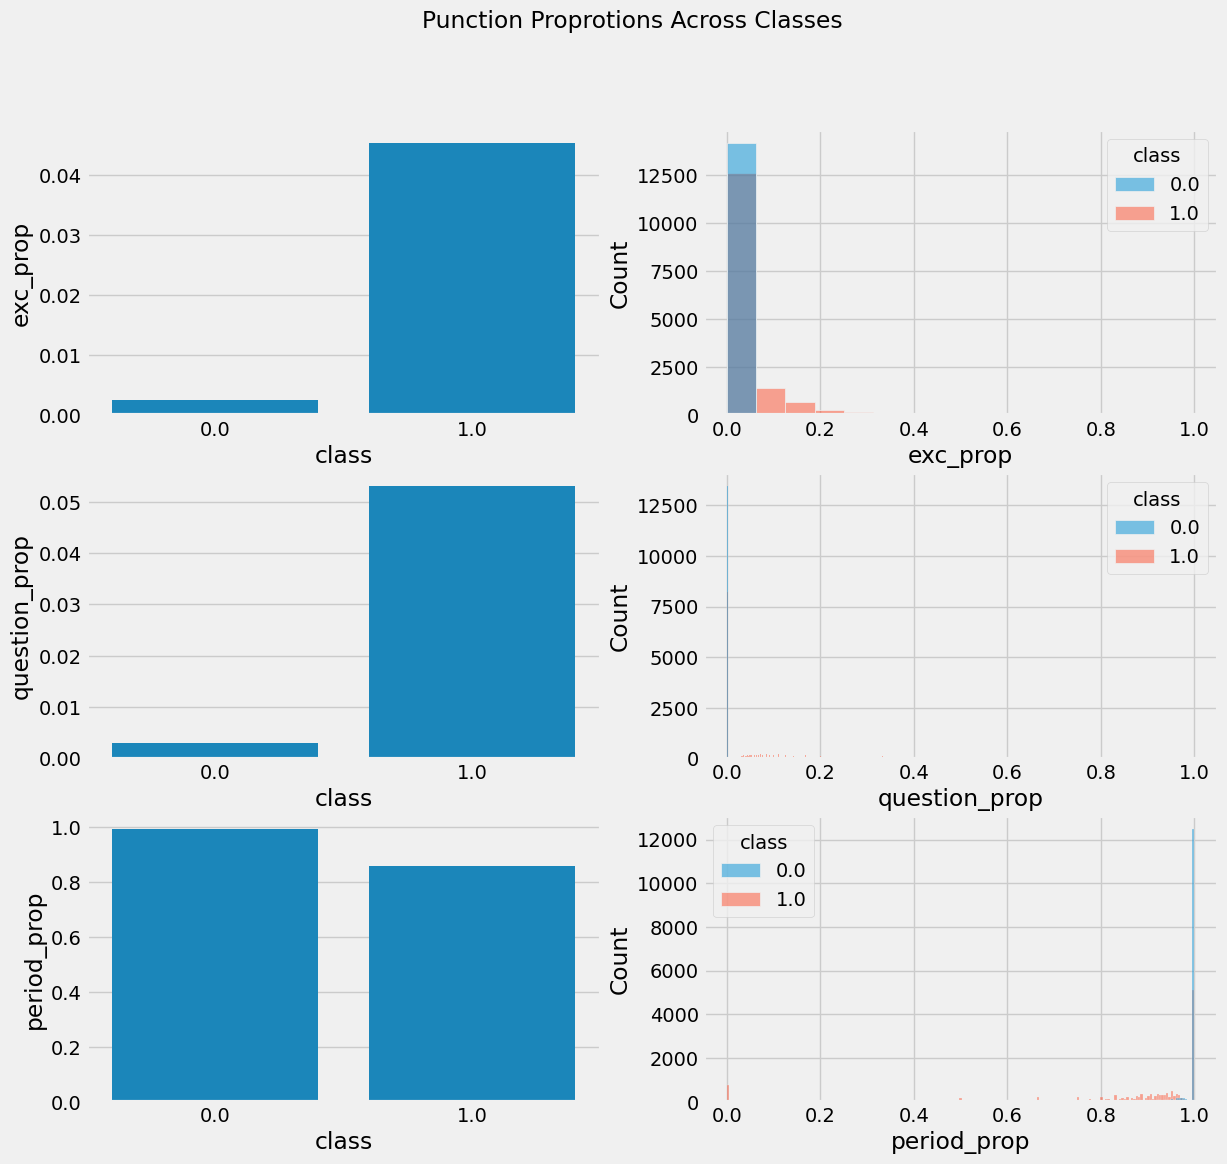

In [522]:
fig, axes = plt.subplots(3, 2, figsize = (13, 12))

sns.barplot(X_train.groupby('class')['exc_prop'].mean(), ax = axes[0][0]);
sns.histplot(data = X_train, x = 'exc_prop', hue = 'class', ax = axes[0][1]);



sns.barplot(X_train.groupby('class')['question_prop'].mean(), ax = axes[1][0]);
sns.histplot(data = X_train, x = 'question_prop', hue = 'class', ax = axes[1][1]);


sns.barplot(X_train.groupby('class')['period_prop'].mean(), ax = axes[2][0]);
sns.histplot(data = X_train, x = 'period_prop', hue = 'class', ax = axes[2][1]);

plt.suptitle('Punction Proprotions Across Classes');



**Word Proportions**



In [510]:
vocab = X_train['text'].str.lower()

def process_text(df, col = 'text'):
    vocab = df[col].str.lower()
    translation_table = str.maketrans('', '', string.punctuation)
    def remove_punctuation(string):
        return ''.join([s.translate(translation_table) for s in string])
    vocab = vocab.apply(remove_punctuation)
    vocab = vocab.replace("'", " ").replace('"', '')
    
    return vocab

processed_text = process_text(X_train)

In [511]:
def word_proportions(df, n, col = 'text'):
    processed_text = process_text(df, col = col)
    fake = process_text(df[df['class'] == 1], col = col)
    real = process_text(df[df['class'] == 0],col = col)

    s = ' '.join(processed_text).split(' ')
    frequencies = Counter(s).most_common(n)
    def class_prop(word):
        fake_prop = sum(fake.str.contains(word))/len(fake)
        real_prop = sum(real.str.contains(word))/len(real)
        return fake_prop - real_prop

    words = [word[0] for word in frequencies]
    word_props = [class_prop(word[0]) for word in frequencies]

    return pd.Series(word_props, words)

props = word_proportions(X_train, 500).sort_values(ascending = False)

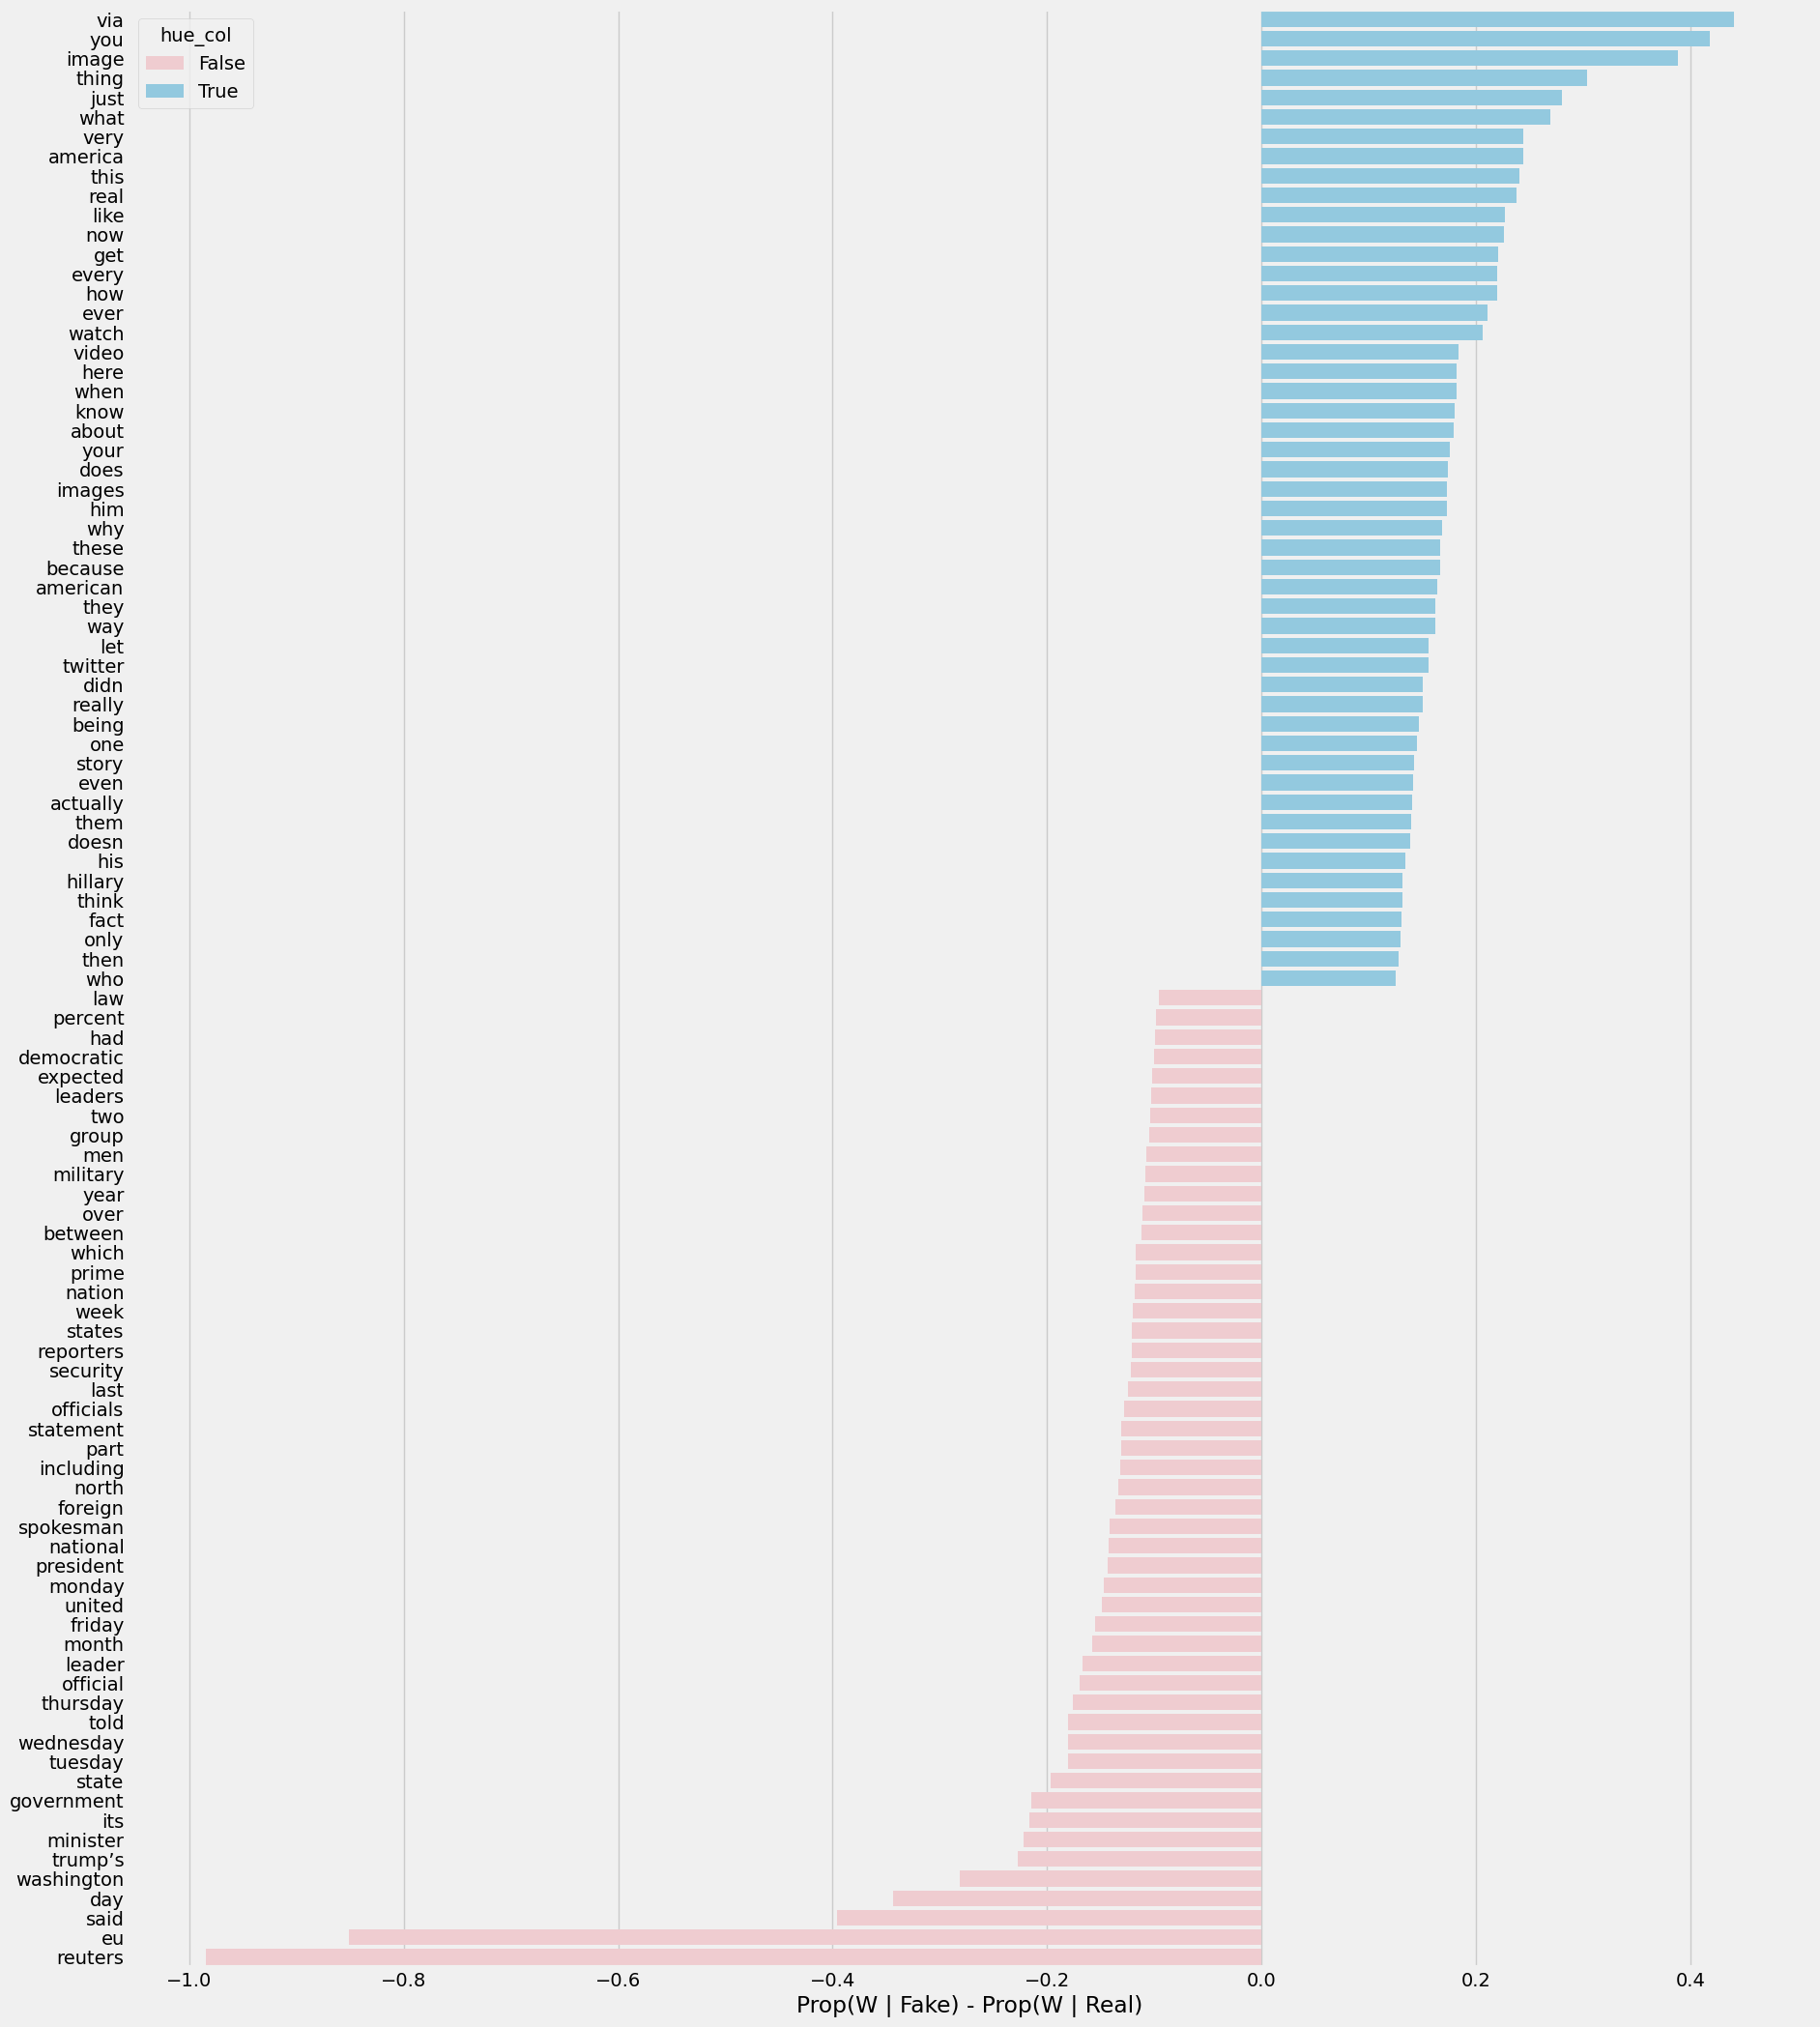

In [524]:
words = pd.DataFrame(pd.concat([props.head(50), props.tail(50)], axis = 0))
words = words.rename(columns={0: 'Fake_Real_Spread'})
words['hue_col'] = words['Fake_Real_Spread'] > 0
plt.figure(figsize=(20, 25))
sns.barplot(data = words, y = words.index, x = 'Fake_Real_Spread', hue = 'hue_col', orient= 'h', palette={True: '#87ceeb', False: '#f5c6cb'});
plt.ylabel("");
plt.xlabel('Prop(W | Fake) - Prop(W | Real)');

Here we can see reuters, eu, washington, government and said are the top 5 words that appear in a much larger proportion of real news than fake. Conversely, video, hillary, twitter, via, you, image, and thing all appear in a much larger proportion of fake news than real news. 

In [513]:
def create_word_feature(word, df = X_train, text = processed_text):
    binary_col = text.str.contains(word).astype(int)
    df = df.copy()
    df[f'contains_{word}'] = binary_col
    return df
words = ['reuters', 'eu', 'washington', 'government', 'said', 'video', 'hillary', 'twitter', 'via', 'you', 'image', 'thing']
# for word in words:
#     X_train = create_word_feature(word, df = X_train)

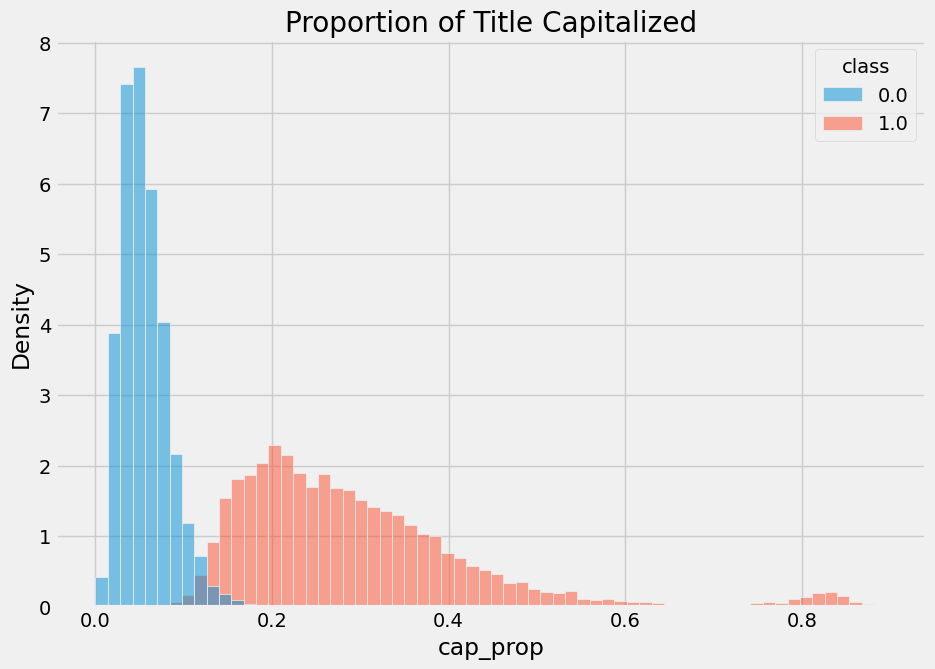

In [514]:
def capital_proportion(s):
    count = 0
    for char in s:
        if char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
            count = count + 1
    
    return count/len(s)

X_train['cap_prop'] = X_train['title'].apply(capital_proportion)
plt.figure(figsize = (10, 7))
sns.histplot(data = X_train, x = 'cap_prop', hue = 'class', stat = 'density');
plt.title('Proportion of Title Capitalized');


**Data Transformation Pipeline**

In [515]:

pd.set_option('display.max_columns', None)
col_lst = ['cap_prop', 'period_prop', 'contains_reuters', 'contains_eu', 'contains_washington', 'contains_government', 'contains_said', 'contains_said', 'contains_hillary', 'contains_twitter', 'contains_via', 'contains_you', 'contains_image', 'contains_thing']


In [516]:
def Pipeline(df, words, cols = col_lst, test = False):
    df['period_prop'] = count_punct_prop('.', df = df)
    df['cap_prop'] = df['title'].apply(capital_proportion)
    processed_text = process_text(df)
    
    for word in words:
        df = create_word_feature(word, df = df, text = processed_text)
    
    if test:
        df = df.drop(columns = ['class'])
    
    df = df[cols]
    
    return df
    
dm = Pipeline(X_test, words = words, cols = col_lst, test = True)


In [517]:
model = LogisticRegression()
parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [10, 50, 100, 1000], 'solver': [ "liblinear",  "newton-cg", "newton-cholesky"]}
gs = GridSearchCV(model, parameters)
gs.fit(dm, y_test)
Y_pred = gs.best_estimator_.predict(dm)

**Model Evaluation**

In [518]:

Y_prob = gs.predict_proba(dm)[:, 0]
accuracy = sum(y_test['class']  == Y_pred)/len(dm)
precision = 7738/(7738 + 14) # TP/TP + FP (What proportion of positve predictions are actually positive)
recall = 7738/(7738 + 21) # Of all the observations that were 1 what proportion were predicted to be 1.
TPR = 7738/(7738 + 21)
TNR = 7044/(7044 + 14)
print(f'Model Accuracy: {accuracy}')
print(f'Model Precision: {precision}')
print(f'Model Recal: {recall}')


Model Accuracy: 0.9976378484173585
Model Precision: 0.9981940144478845
Model Recal: 0.9972934656527903


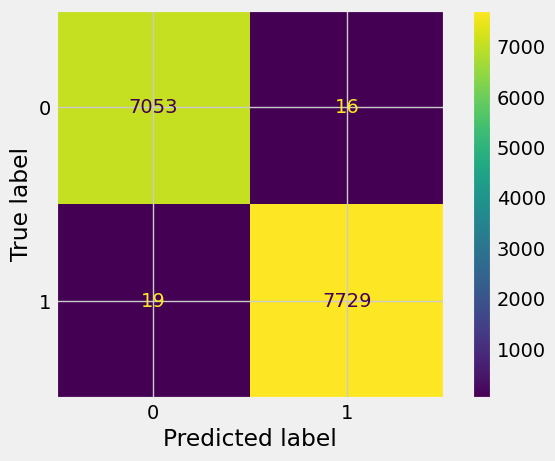

In [519]:
cm = confusion_matrix(y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();


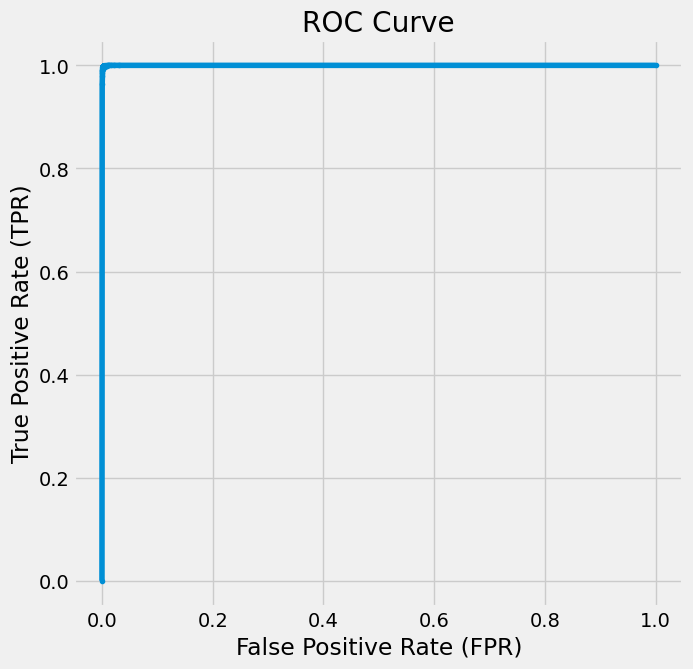

In [520]:
TPR_lst = []
FPR_lst = []

#
thresholds = np.linspace(0.0, 1.0, num=100)  #

for t in thresholds:
    
    lst = (Y_prob >= t).astype(int)
    
    
    temp_cm = confusion_matrix(y_test, lst)
    
    
    TP = temp_cm[1, 1] if temp_cm.shape[0] > 1 and temp_cm.shape[1] > 1 else 0
    TN = temp_cm[0, 0] if temp_cm.shape[0] > 1 and temp_cm.shape[1] > 1 else 0
    FP = temp_cm[0, 1] if temp_cm.shape[0] > 1 and temp_cm.shape[1] > 1 else 0
    FN = temp_cm[1, 0] if temp_cm.shape[0] > 1 and temp_cm.shape[1] > 1 else 0
    
    
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    
    
    TPR_lst.append(TPR)
    FPR_lst.append(FPR)


plt.figure(figsize=(7, 7))
plt.plot(TPR_lst, FPR_lst,  marker='.')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.show()


From the reciever operating curve  (ROC Curve) we can see that the predictor is practically perfect with true positive rate of nearly 1 and false positive rate of nearly 0. It takes on the right angle form characteristic of the perfect predictor.